## Import Dependencies

Make sure to use the following versions:
- python 3.6.12
- pyfolio 0.8.0
- pandas 0.22.0
- matplotlib 3.0.3
- numpy 1.19.5

Otherwise, if receiving `IndexError` during analyzing the algo results, follow [this answer](https://github.com/quantopian/pyfolio/issues/661#issuecomment-742053547) and update pyfolio files.

In [2]:
import logging
from datetime import datetime

import pandas as pd
import zipline as zp
import yfinance as yf
import pyfolio as pf

## Parameters
Store parameters in global constants to facilitate making changes and running parameter optimization functions. Regarding percentages, for simplifying calculations, total percentage is used. For example, if the value of `STOP_LOSS_PCT` is 0.95, it means the price must decrease by 5%.

In [3]:
WATCHLIST_WINDOW_DAYS = 30
ABOVE_PIVOT_PCT = 1.01
TAKE_PROFIT_PCT = 1.15
STOP_LOSS_PCT = .95
PATIENCE_WINDOW_DAYS = 21
START = datetime(2016, 1, 1)
END = datetime(2018, 1, 1)
BENCHMARK = "SPY"
SHORT_MA_LEN = 50
LONG_MA_LEN = 200

## Algorithm
Algorithm buys shares of an asset if:
- Name exists in list of patterns (stored in `data/patterns.csv`) 
- Less than `PATIENCE_WINDOW_DAYS` has been passed since pattern's handle low date
- Price has broken out of pivot level (that is, last cup high) by more than `ABOVE_PIVOT_PCT`
- Short-term moving average is above long-term moving average (periods defined in `SHORT_MA_LEN` and `LONG_MA_LEN`)

And sells shares if:
- Price moved up by `TAKE_PROFIT_PCT`
- Price moved down by `STOP_LOSS_PCT`
- `PATIENCE_WINDOW_DAYS` or more days have been passed

In [8]:
def convert_date_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Given a dataframe, adds UTC timezone to all columns that have date in their names."""
    for col in df.columns:
        if("date" in col.lower()):
            df[col] = pd.to_datetime(df[col]).dt.tz_localize("UTC")
    return df

def initialize(context):
    # avoid out of bounds error by dropping firstBottomDate col
    patterns = pd.read_csv("data/patterns.csv").drop(["firstBottomDate"], axis=1)
    patterns = convert_date_cols(patterns)
    context.patterns = patterns

    tickers = pd.read_csv("data/tickers.csv")
    tickers = convert_date_cols(tickers)
    context.stocks = [zp.api.symbol(ticker) for ticker in tickers.symbol]

    context.position_dates = {}

def handle_data(context, data):
    current_dt = zp.api.get_datetime()

    watchlist_patterns = []
    prices = data.history(context.stocks, "price", bar_count=200, frequency="1d")
    
    for ix, pattern in context.patterns.iterrows():
        open_positions = set(context.portfolio.positions.keys())
        symbol = zp.api.symbol(pattern["symbol"])
        is_open = symbol in open_positions
        if(is_open): continue

        # check date window from handleLowDate to N days after
        is_in_window = (pattern["handleLowDate"] <= current_dt) and (pattern["handleLowDate"] >= (current_dt - pd.DateOffset(WATCHLIST_WINDOW_DAYS)))
        if (not is_in_window): continue
        
        # get symbol and price history
        price_history = prices[symbol]

        # get pivot price
        pivot_price_date = pattern["pivotPriceDate"]
        try:
            pivot_price = price_history[pivot_price_date]
        except KeyError:
            pivot_price = None
        
        # check price above pivot
        current_price = data.current(symbol, "price")
        if(current_price / pivot_price < ABOVE_PIVOT_PCT): continue

        # check short MA above long MA
        short_ma = price_history.tail(SHORT_MA_LEN).mean()
        long_ma = price_history.tail(LONG_MA_LEN).mean()
        if(long_ma > short_ma): continue

        # add new position and update previous ones
        open_positions.add(symbol)
        target_pct = 1 / len(open_positions)
        for position in open_positions:
            zp.api.order_target_percent(position, target_pct)
        context.position_dates[symbol] = current_dt
    
    open_positions = context.portfolio.positions
    for position in open_positions.values():
        current_price = position.last_sale_price
        buy_price = position.cost_basis
        should_take_profit = (current_price / buy_price) > TAKE_PROFIT_PCT
        should_stop_loss = (current_price / buy_price) < STOP_LOSS_PCT
        does_exceed_patience = (current_dt - pd.DateOffset(PATIENCE_WINDOW_DAYS)) >= context.position_dates[position.asset]
        should_close_position = should_take_profit or does_exceed_patience or should_stop_loss
        if(should_close_position): zp.api.order_target_percent(position.asset, 0)

## Benchmark Returns
Fetch and format benchmark returns. Note that `zipline` and `pyfolio` receive benchmark returns as a `pd.Series`. Check out [this method](https://github.com/quantopian/zipline/blob/master/zipline/data/benchmarks.py#L22) on how to load benchmark data from a file.

In [6]:
def get_benchmark_returns() -> pd.Series:
    bench = yf.Ticker(BENCHMARK)
    bench_hist = bench_hist.history(start=START, end=END, auto_adjust=True).tz_localize("UTC")
    returns = pd.Series(bench_hist["Close"].pct_change().values, index=bench_hist.index).dropna()
    returns.index.names = ["date"]
    return returns

## Analyze

In [5]:
def analyze(perf: pd.DataFrame, bench):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_full_tear_sheet(returns=returns, benchmark_rets=bench)


## Execute

/Users/aliakh/Documents/GitHub/blog/marketsmith_pr_zipline/env/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/aliakh/Documents/GitHub/blog/marketsmith_pr_zipline/env/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Start date,2016-01-04
End date,2017-12-29
Total months,23
,Backtest
Annual return,9.7%
Cumulative returns,20.2%
Annual volatility,7.5%
Sharpe ratio,1.27
Calmar ratio,1.96
Stability,0.91
Max drawdown,-4.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.93,2017-07-24,2017-07-27,2017-11-06,76
1,3.95,2017-11-09,2017-11-15,NaT,NaN
2,2.87,2016-11-28,2016-12-01,2016-12-07,8
3,2.63,2017-01-27,2017-02-10,2017-04-11,53
4,2.36,2016-03-04,2016-03-14,2016-03-18,11


/Users/aliakh/Documents/GitHub/blog/marketsmith_pr_zipline/env/lib/python3.8/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.04%,-2.77%,5.56%


/Users/aliakh/Documents/GitHub/blog/marketsmith_pr_zipline/env/lib/python3.8/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


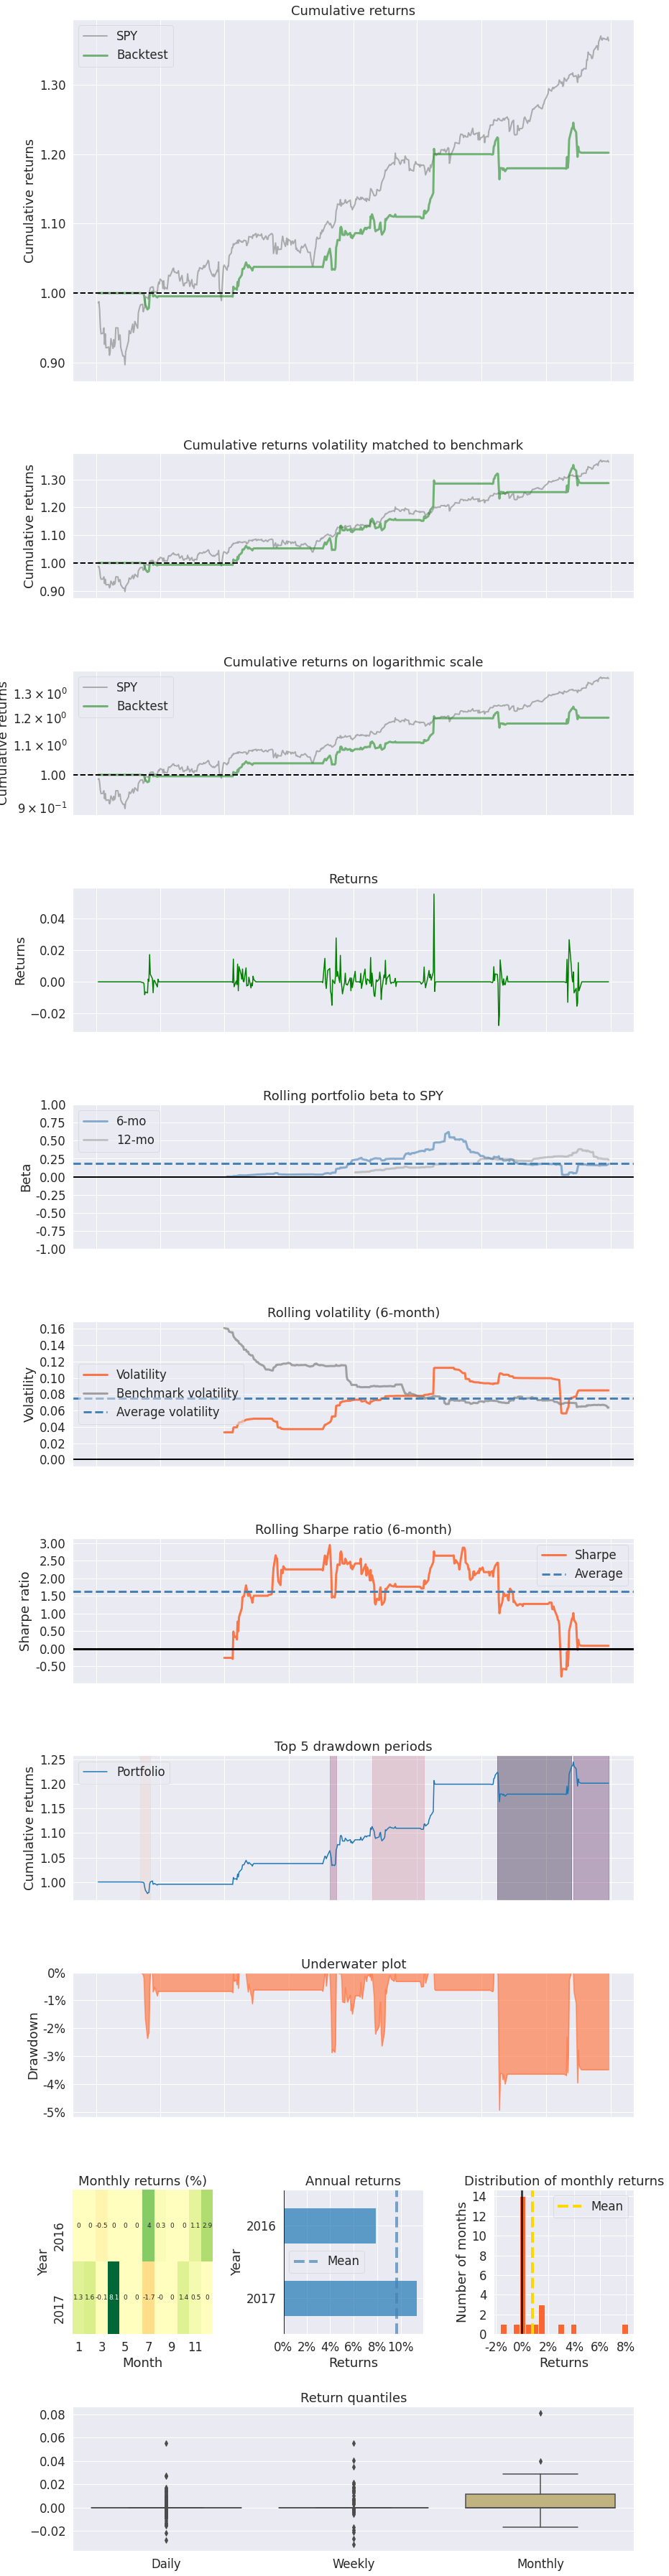

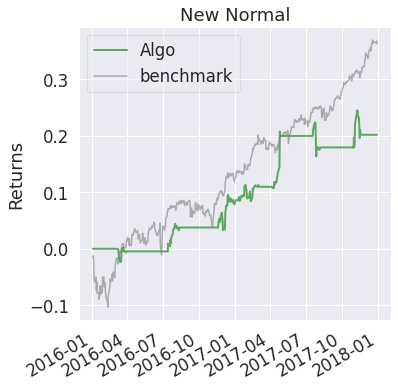

In [6]:
start = pd.Timestamp(START).tz_localize("UTC")
end = pd.Timestamp(END).tz_localize("UTC")

benchmark = get_benchmark_returns()
results = zp.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    handle_data=handle_data,
    benchmark_returns=benchmark,
    capital_base=10000000,
    bundle='quandl',
    data_frequency='daily')
analyze(results, benchmark)
results.to_csv("results.csv")